In [1]:
import os
import sys

sys.path.insert(0, os.path.abspath("..")) 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from models import Haldane
from pythtb import *
from wanpy import *

In [3]:
# tight-binding parameters
delta = 1
t = 1
t2 = -0.3

n_super_cell = 2
model = Haldane(delta, t, t2).make_supercell([[n_super_cell, 0], [0, n_super_cell]])

#############

low_E_sites = np.arange(0, model.get_num_orbitals(), 2)
high_E_sites = np.arange(1, model.get_num_orbitals(), 2)
lat_vecs = model.get_lat()
recip_lat_vecs = model.get_recip_lat_vecs()
orb_vecs = model.get_orb()
n_orb = model.get_num_orbitals()
n_occ = int(n_orb/2)

u_wfs_full = wf_array(model, [20, 20])
u_wfs_full.solve_on_grid([0, 0])
chern = u_wfs_full.berry_flux([i for i in range(n_occ)])/(2*np.pi)

model_str = f'C={chern:.1f}_Delta={delta}_t={t}_t2={t2}'

print(f"Low energy sites: {low_E_sites}")
print(f"High energy sites: {high_E_sites}")
print(f"Chern # occupied: {chern: .1f}")

Low energy sites: [0 2 4 6]
High energy sites: [1 3 5 7]
Chern # occupied:  1.0


In [4]:
### Trial wavefunctions
omit_sites = 6
tf_list = list(np.setdiff1d(low_E_sites, [omit_sites])) 
# tf_list = list(low_E_sites)

n_tfs = len(tf_list)
Wan_frac = n_tfs/n_occ

save_sfx = model_str + f'_tfx={np.array(tf_list, dtype=int)}'

print(f"Trial wavefunctions: {tf_list}")
print(f"# of Wannier functions: {n_tfs}")
print(f"# of occupied bands: {n_occ}")
print(f"Wannier fraction: {Wan_frac}")
print(save_sfx)

Trial wavefunctions: [np.int64(0), np.int64(2), np.int64(4)]
# of Wannier functions: 3
# of occupied bands: 4
Wannier fraction: 0.75
C=1.0_Delta=1_t=1_t2=-0.3_tfx=[0 2 4]


In [5]:
k_path = [[0, 0], [2/3, 1/3], [.5, .5], [1/3, 2/3], [0, 0], [.5, .5]]
k_label = (r'$\Gamma $',r'$K$', r'$M$', r'$K^\prime$', r'$\Gamma $', r'$M$')
(k_vec, k_dist, k_node) = model.k_path(k_path, 101, report=False)

In [6]:
sv_dir = 'data'
if not os.path.exists(sv_dir):
    os.makedirs(sv_dir)
    
sv_prefix = 'WF_max_loc'
file_name = f"{sv_dir}/{sv_prefix}_{save_sfx}"

WF = np.load(f"{file_name}.npy", allow_pickle=True).item()

In [7]:
nks = WF.k_mesh.nks
Nk = np.prod(nks)
N_cells = np.prod([ nk -1 for nk in nks])
A_plaq = model.get_recip_vol() / (N_cells)

# Energy eigstates on full mesh
Bloch_en = WF.energy_eigstates
u_energy = Bloch_en.get_states()["Cell periodic"]  # energy eigenstates
P, Q = Bloch_en.get_projector(return_Q=True)  # full band projector

# occupied energy eigenstates
u_occ = u_energy[..., :n_occ, :]  # occupied energy eigenstates
Bloch_occ = Bloch(model, u_occ.shape[0], u_occ.shape[1])
Bloch_occ.set_wfs(u_occ, cell_periodic=True)
P_occ, Q_occ = Bloch_occ.get_projector(return_Q=True)

# tilde states
u_tilde = WF.tilde_states.get_states()["Cell periodic"]  # reduced tilde states
Bloch_tilde = Bloch(model, u_tilde.shape[0], u_tilde.shape[1])
Bloch_tilde.set_wfs(u_tilde, cell_periodic=True)
P_tilde, Q_tilde = Bloch_tilde.get_projector(return_Q=True)  # tilde space projectors

# topological states
P_diff = P_occ - P_tilde  # complementary subspace
eigvals, eigvecs = np.linalg.eigh(P_diff)  # states spanning complement
u_comp = eigvecs[..., :, -1]  # take state with non-zero eigval
u_comp = u_comp[..., np.newaxis, :]  # single state
Bloch_comp = Bloch(model, u_comp.shape[0], u_comp.shape[1])
Bloch_comp.set_wfs(u_comp, cell_periodic=True)

In [8]:
# Occupied states
Berry_curv = Bloch_occ.berry_flux_plaq() / A_plaq
omega_i_k = Bloch_occ.trace_metric() #[..., np.newaxis]
omega_i = np.sum(omega_i_k) / Nk

# Reduced (trivial) states  
Berry_curv_til = Bloch_tilde.berry_flux_plaq() / A_plaq
omega_i_k_til = Bloch_tilde.trace_metric() #[..., np.newaxis]
omega_i_til = np.sum(omega_i_k_til) / Nk
omega_til_til = Bloch_tilde.omega_til()

# Complementary (topological) states 
Berry_curv_comp = Bloch_comp.berry_flux_plaq() / A_plaq
omega_i_k_comp = Bloch_comp.trace_metric() #[..., np.newaxis]
omega_i_comp = np.sum(omega_i_k_comp) / Nk
omega_til_comp = Bloch_comp.omega_til()

Computing flux in plane: mu=0, nu=1
Computing flux in plane: mu=0, nu=1
Computing flux in plane: mu=0, nu=1


In [9]:
print(f"Chern occupied: {A_plaq * np.sum(Berry_curv[0,1])/(2*np.pi)}")
print(f"Chern reduced: {A_plaq * np.sum(Berry_curv_til[0,1])/(2*np.pi)}")
print(f"Chern complement: {A_plaq * np.sum(Berry_curv_comp[0,1])/(2*np.pi)}")

Chern occupied: (1+0j)
Chern reduced: (-2.409772367336469e-16+0j)
Chern complement: (1.0000000000000002+0j)


In [10]:
print(f"Omega_I occupied: {omega_i}")
print(f"Omega_I reduced: {omega_i_til}")
print(f"Omega_I complement: {omega_i_comp}")
print(f"Omega_tilde reduced: {omega_til_til}")
print(f"Omega_tilde comeplement: {omega_til_comp}")

Omega_I occupied: (0.5885816431929308+1.7262656963607755e-17j)
Omega_I reduced: (0.5706005404461187+1.354208511117207e-17j)
Omega_I complement: (0.6295961584678988-1.0000710389846503e-17j)
Omega_tilde reduced: 0.034913530260350815
Omega_tilde comeplement: 11.230691454014766


# Quantum Metric

In [11]:
k_mesh = Bloch_en.k_mesh
full_mesh = k_mesh.gen_k_mesh(endpoint=False)
full_mesh_mat = k_mesh.gen_k_mesh(flat=False, endpoint=False)
mesh_Cart = full_mesh_mat @ recip_lat_vecs

KX = mesh_Cart[:, :, 0]
KY = mesh_Cart[:, :, 1]

kx_shape = KX.shape[0]
ky_shape = KY.shape[0]

# Define the number of tiles in each direction
Nx, Ny = 3, 3  # Number of times to tile in x and y directions

# Expand KX, KY, and omega_i_k to the size of the tiled grid
KX_tiled = np.tile(KX, (Nx, Ny))  # Tile KX Nx times along x and Ny times along y
KY_tiled = np.tile(KY, (Nx, Ny))

# Apply reciprocal lattice translations to each tile
for i in range(Nx):
    for j in range(Ny):
        # Apply the appropriate translation for each tile
        KX_tiled[i *kx_shape :(i + 1) * kx_shape, j * ky_shape:(j + 1) * ky_shape] += i * recip_lat_vecs[0, 0] + j * recip_lat_vecs[1, 0]
        KY_tiled[i * kx_shape:(i + 1) * kx_shape, j * ky_shape:(j + 1) * ky_shape] += i * recip_lat_vecs[0, 1] + j * recip_lat_vecs[1, 1]

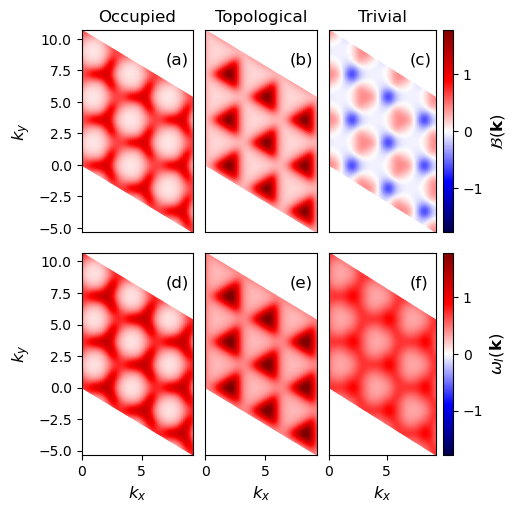

In [12]:
fig = plt.figure(figsize=(5, 5))
gs = fig.add_gridspec(2, 3, wspace=0.1, hspace=0.1, width_ratios=[1, 1, 1.28])
ax = gs.subplots(sharex='col', sharey='row')

###################### Berry Curve #######################

max_Bcurv = np.amax([np.amax(Berry_curv), np.amax(Berry_curv_comp), np.amax(Berry_curv_til)])
vmin, vmax = -max_Bcurv.real, max_Bcurv.real

### occupied subspace
Berry_curv_tiled = np.tile(Berry_curv[0,1].real, (Nx, Ny))
im = ax[0,0].pcolormesh(KX_tiled, KY_tiled, Berry_curv_tiled, cmap='seismic', shading='gouraud', vmin=vmin, vmax=vmax)
# plt.colorbar(im, label=r'$\Omega(\mathbf{k})$')

# ax[0,0].set_xlabel('$k_x$', size=12)
ax[0,0].xaxis.set_visible(False)
# ax[0,0].yaxis.set_visible(False)
ax[0,0].set_ylabel('$k_y$', size=12)
ax[0,0].set_title(r'Occupied')
# ax[0,0].set_aspect('equal')

### reduced subspace
Berry_curv_tiled = np.tile(Berry_curv_til[0,1].real, (Nx, Ny))

im = ax[0,2].pcolormesh(KX_tiled, KY_tiled, Berry_curv_tiled, cmap='seismic', shading='gouraud', vmin=vmin, vmax=vmax)
cb = plt.colorbar(im, fraction=0.2)
cb.set_label('$\mathcal{B}(\mathbf{k})$', size=12)

# ax[0,2].set_xlabel('$k_x$', size=12)
ax[0,2].xaxis.set_visible(False)
ax[0,2].yaxis.set_visible(False)
ax[0,2].set_title(r'Trivial')
# ax[0,2].set_aspect('equal')

### complementary subspace
# omega_i_k_tiled = np.tile(omega_i_k_comp[:, :, 0].real, (Nx, Ny))
Berry_curv_tiled = np.tile(Berry_curv_comp[0,1].real, (Nx, Ny))

# Plotting
im = ax[0,1].pcolormesh(KX_tiled, KY_tiled, Berry_curv_tiled, cmap='seismic', shading='gouraud', vmin=vmin, vmax=vmax)
# plt.colorbar(im, label=r'$\Omega(\mathbf{k})$', fraction=0.087)

# ax[0,1].set_xlabel('$k_x$', size=12)
ax[0,1].xaxis.set_visible(False)
ax[0,1].yaxis.set_visible(False)
ax[0,1].set_title(r'Topological')
# ax[0,1].set_aspect('equal')

################## omega_I ##########################

# vmin = 0
# vmax = np.amax([np.amax(omega_i_k), np.amax(omega_i_k_comp), np.amax(omega_i_k_til)]).real

### occupied subspace
omega_i_k_tiled = np.tile(omega_i_k.real, (Nx, Ny))
im = ax[1, 0].pcolormesh(KX_tiled, KY_tiled, omega_i_k_tiled, cmap='seismic', shading='gouraud', vmin=vmin, vmax=vmax)
# plt.colorbar(im, label=r'$\omega_I(\mathbf{k})$')

ax[1, 0].set_xlabel('$k_x$', size=12)
ax[1, 0].set_ylabel('$k_y$', size=12)
# ax[1, 0].set_title(r'Occupied')
# ax[1, 0].set_aspect('equal')

### reduced subspace
omega_i_k_tiled = np.tile(omega_i_k_til.real, (Nx, Ny))

# vmin, vmax = 0.000, np.amax(omega_i_k_comp)
# vmin, vmax = None, None
im = ax[1, 2].pcolormesh(KX_tiled, KY_tiled, omega_i_k_tiled, cmap='seismic', shading='gouraud', vmin=vmin, vmax=vmax)
cb = plt.colorbar(im, fraction=0.2)
# cb.set_ticks([0, 1])
cb.set_label('$\omega_I(\mathbf{k})$', size=12)

ax[1, 2].set_xlabel('$k_x$', size=12)
ax[1, 2].yaxis.set_visible(False)
# ax[1, 2].set_title(r'Reduced')
# ax[1, 2].set_aspect('equal')

### complementary subspace
omega_i_k_tiled = np.tile(omega_i_k_comp.real, (Nx, Ny))

# vmin, vmax = 0.000, np.amax(omega_i_k_comp)
# vmin, vmax = None, None
im = ax[1,1].pcolormesh(KX_tiled, KY_tiled, omega_i_k_tiled, cmap='seismic', shading='gouraud', vmin=vmin, vmax=vmax)
# plt.colorbar(im, label=r'$\Omega(\mathbf{k})$', fraction=0.087)

ax[1, 1].set_xlabel('$k_x$', size=12)
ax[1, 1].yaxis.set_visible(False)
# ax[1, 1].set_title(r'Complementary')
# ax[1, 1].set_aspect('equal')

# plt.subplots_adjust(wspace=-0.5)

let = np.array([['a', 'b', 'c'], ['d', 'e', 'f']])
for row in range(ax.shape[0]):
    for col in range(ax.shape[1]):
        ax[row, col].text(7, 8, f'({let[row, col]})', size=12)

plt.subplots_adjust(top=0.95, left=0.14, bottom=0.1, right=0.92)
# fig.set_constrained_layout_pads(w_pad=-0.5)
plt.savefig(f"figures/fig6_berry_curv_and_omega_I_{save_sfx}.png", dpi=700)

In [13]:
Berry_curv_comp.shape

(2, 2, 20, 20)

In [14]:
k_mesh = np.copy(Bloch_comp.k_mesh.square_mesh)
k_idx_arr = Bloch_comp.k_mesh.idx_arr

print(k_mesh.shape)

(20, 20, 2)


In [15]:
k_idx_arr[5]

array([0, 5])

In [16]:
k_path = [[0, 0], [2/3, 1/3], [.5, .5], [1/3, 2/3], [0, 0], [.5, .5]]
k_label = (r'$\Gamma $',r'$K$', r'$M$', r'$K^\prime$', r'$\Gamma $', r'$M$')
# k_path = [[0, 0], [-.5, -.5], [0,0], [.5, .5]]
# k_label = (r'$\Gamma $', r'$M$', r'$\Gamma $', r'$M$')
(k_vec, k_dist, k_node) = model.k_path(k_path, 101, report=False)

Berry_curv_comp_path = Bloch_comp.interp_op(Berry_curv_comp[0,1], k_vec, plaq=True)
Berry_curv_til_path = Bloch_tilde.interp_op(Berry_curv_til[0,1], k_vec, plaq=True)
Berry_curv_path = Bloch_occ.interp_op(Berry_curv[0,1], k_vec, plaq=True)

omega_i_k_path = Bloch_occ.interp_op(omega_i_k, k_vec)
omega_i_k_til_path = Bloch_tilde.interp_op(omega_i_k_til, k_vec)
omega_i_k_comp_path = Bloch_comp.interp_op(omega_i_k_comp, k_vec)

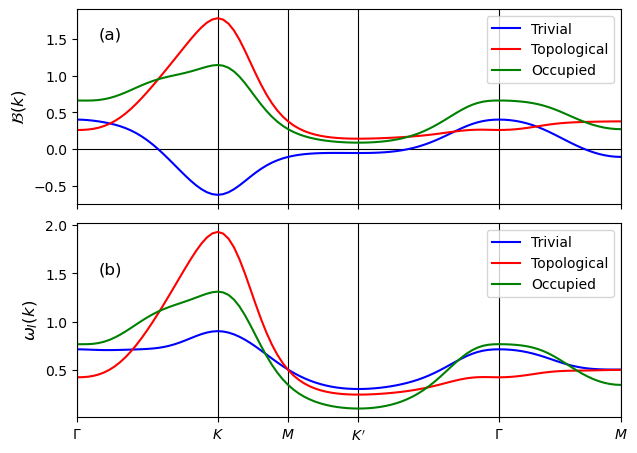

In [17]:
fig, ax = plt.subplots(2, 1, sharex=True)

ax[0].set_xlim(0, k_node[-1])
ax[0].set_xticks(k_node)
for n in range(len(k_node)):
    ax[0].axvline(x=k_node[n], linewidth=0.8, color='k')
if k_label is not None:
    ax[0].set_xticklabels(k_label, size=12)

ax[0].plot(k_dist, Berry_curv_til_path.real, c='b', label='Trivial')
ax[0].plot(k_dist, Berry_curv_comp_path.real, c='r', label='Topological')
ax[0].plot(k_dist, Berry_curv_path.real, c='g', label='Occupied')

ax[0].set_ylabel(r'$\mathcal{B}(k)$', size=12)
ax[0].legend()
ax[0].text(0.05, 1.5, '(a)', size=12)
ax[0].axhline(y=0, linewidth=0.8, color='k', zorder=0)

ax[1].set_xlim(0, k_node[-1])
ax[1].set_xticks(k_node)
for n in range(len(k_node)):
    ax[1].axvline(x=k_node[n], linewidth=0.8, color='k')
# if k_label is not None:
#     ax[1].set_xticklabels(k_label, size=12)

ax[1].plot(k_dist, omega_i_k_til_path.real, c='b', label='Trivial')
ax[1].plot(k_dist, omega_i_k_comp_path.real, c='r', label='Topological')
ax[1].plot(k_dist, omega_i_k_path.real, c='g', label='Occupied')
ax[1].set_ylabel(r'$\omega_I(k)$', size=12)
ax[1].legend()
ax[1].text(0.05, 1.5, '(b)', size=12)


plt.subplots_adjust(top=0.95, left=0.12, bottom=0.1, right=0.97, hspace=0.1)
plt.savefig(f"figures/fig7_berry_curv_and_omega_I_interp_{save_sfx}.png", dpi=700)

In [18]:
# tight-binding parameters
delta = 1
t = 1
t2 = -0.3

n_super_cell = 2
model = Haldane(delta, t, t2).make_supercell([[n_super_cell, 0], [0, n_super_cell]])

#############

low_E_sites = np.arange(0, model.get_num_orbitals(), 2)
high_E_sites = np.arange(1, model.get_num_orbitals(), 2)
lat_vecs = model.get_lat()
recip_lat_vecs = model.get_recip_lat_vecs()
orb_vecs = model.get_orb()
n_orb = model.get_num_orbitals()
n_occ = int(n_orb/2)

bloch_wfs = Bloch(model, 20, 20)
bloch_wfs.solve_model()
chern = bloch_wfs.chern_num()

model_str = f'C={chern:.1f}_Delta={delta}_t={t}_t2={t2}'

print(f"Low energy sites: {low_E_sites}")
print(f"High energy sites: {high_E_sites}")
print(f"Chern # occupied: {chern.real: .1f}")

Computing flux in plane: mu=0, nu=1
Low energy sites: [0 2 4 6]
High energy sites: [1 3 5 7]
Chern # occupied:  1.0


(<Figure size 640x480 with 1 Axes>, <Axes: ylabel='Energy $E(\\mathbf{{k}})$'>)

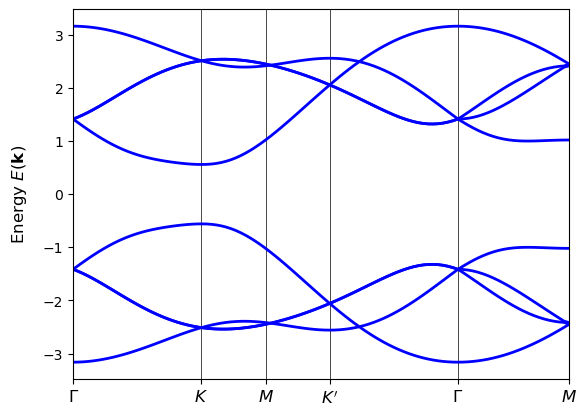

In [29]:
k_path = [[0, 0], [2/3, 1/3], [.5, .5], [1/3, 2/3], [0, 0], [.5, .5]]
k_label = (r'$\Gamma $',r'$K$', r'$M$', r'$K^\prime$', r'$\Gamma $', r'$M$')
(k_vec_sc, k_dist_sc, k_node) = model.k_path(k_path, 101, report=False)

model.plot_bands(k_path=k_path, k_label=k_label)

In [20]:
b_curv_prim = bloch_wfs.berry_flux_plaq(state_idx=np.arange(n_occ), non_abelian=True)[0,1] / A_plaq
b_curv_path = bloch_wfs.interp_op(b_curv_prim, k_vec_sc, plaq=True)

Computing flux in plane: mu=0, nu=1


In [21]:
b_curv_prim = bloch_wfs.berry_flux_plaq(state_idx=np.arange(n_occ))[0,1] / A_plaq

# Assume b_curv is a (20, 20) numpy array
b_curv_folded = np.zeros((10, 10, 4), dtype=complex)

# Layer 0: Q1 (upper left)
b_curv_folded[:, :, 0] = b_curv_prim[0:10, 0:10]

# Layer 1: Q2 (upper right)
b_curv_folded[:, :, 1] = b_curv_prim[0:10, 10:20]

# Layer 2: Q3 (lower left)
b_curv_folded[:, :, 2] = b_curv_prim[10:20, 0:10]

# Layer 3: Q4 (lower right)
b_curv_folded[:, :, 3] = b_curv_prim[10:20, 10:20]

Computing flux in plane: mu=0, nu=1


In [22]:
from itertools import product

nks_fold = b_curv_folded.shape[:-1]
supercell = list(product(*[range(-int((nk-nk%2)/2), int((nk-nk%2)/2)) for nk in nks_fold]))

k_vals = [np.linspace(0, 1, nk, endpoint=False) for nk in nks_fold]
flat = np.array(list(product(*k_vals)))
mesh = flat.reshape(*[nk for nk in nks_fold], len(nks_fold))
mesh += np.array([(1/nk)/2 for nk in nks_fold])
idx_arr = list(product(*[range(nk) for nk in nks_fold]))

O_R = np.zeros((len(supercell), *b_curv_folded.shape[2:]), dtype=complex)
for idx, pos in enumerate(supercell):
    for k_idx in idx_arr:
        R_vec = np.array(pos)
        phase = np.exp(-1j * 2 * np.pi * np.vdot(mesh[k_idx], R_vec))
        O_R[idx] += b_curv_folded[k_idx] * phase / Nk

# interpolate to arbitrary k
b_curv_folded_path = np.zeros((k_vec.shape[0], *b_curv_folded.shape[2:]), dtype=complex)
for k_idx, k in enumerate(k_vec):
    for idx, pos in enumerate(supercell):
        R_vec = np.array(pos)
        phase = np.exp(1j * 2 * np.pi * np.vdot(k, R_vec))
        b_curv_folded_path[k_idx] += O_R[idx] * phase

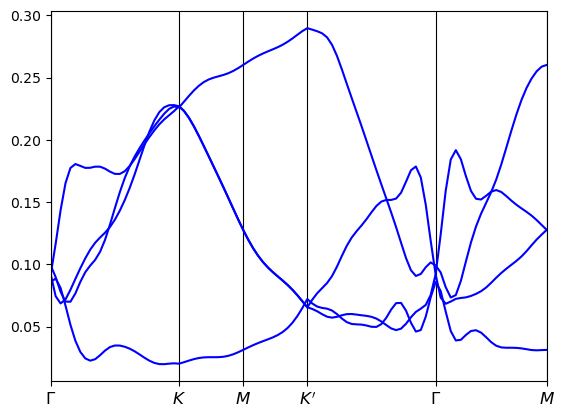

In [23]:
fig, ax = plt.subplots()

ax.set_xlim(0, k_node[-1])
ax.set_xticks(k_node)
for n in range(len(k_node)):
    ax.axvline(x=k_node[n], linewidth=0.8, color='k')
if k_label is not None:
    ax.set_xticklabels(k_label, size=12)


ax.plot(k_dist, b_curv_folded_path.real, c='b', label='Trivial')

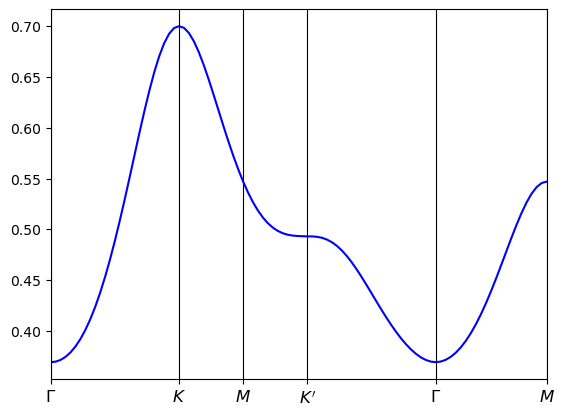

In [24]:
fig, ax = plt.subplots()

ax.set_xlim(0, k_node[-1])
ax.set_xticks(k_node)
for n in range(len(k_node)):
    ax.axvline(x=k_node[n], linewidth=0.8, color='k')
if k_label is not None:
    ax.set_xticklabels(k_label, size=12)


ax.plot(k_dist, np.sum(b_curv_folded_path.real, axis=-1), c='b', label='Trivial')

In [25]:
b_curv_path.diagonal(axis1=-1, axis2=-2).shape

(101, 4)

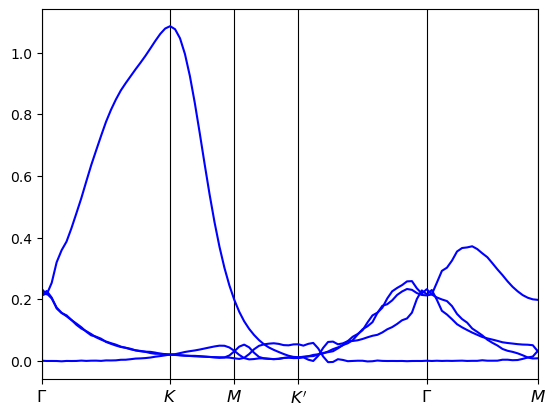

In [31]:
fig, ax = plt.subplots()

ax.set_xlim(0, k_node[-1])
ax.set_xticks(k_node)
for n in range(len(k_node)):
    ax.axvline(x=k_node[n], linewidth=0.8, color='k')
if k_label is not None:
    ax.set_xticklabels(k_label, size=12)

ax.plot(k_dist_sc, b_curv_path.diagonal(axis1=-1, axis2=-2).real, c='b', label='Folded Occupied')

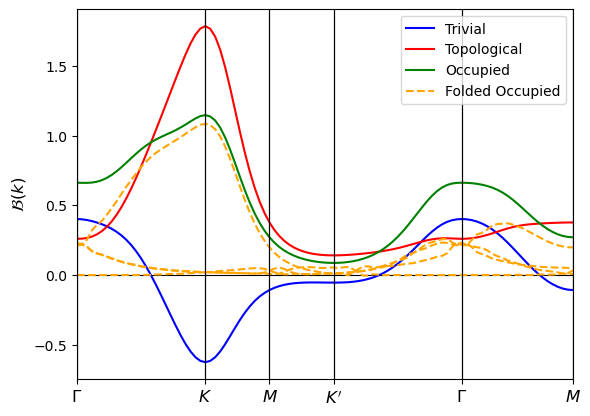

In [30]:
fig, ax = plt.subplots()

ax.set_xlim(0, k_node[-1])
ax.set_xticks(k_node)
for n in range(len(k_node)):
    ax.axvline(x=k_node[n], linewidth=0.8, color='k')
if k_label is not None:
    ax.set_xticklabels(k_label, size=12)

ax.plot(k_dist, Berry_curv_til_path.real, c='b', label='Trivial')
ax.plot(k_dist, Berry_curv_comp_path.real, c='r', label='Topological')
ax.plot(k_dist, Berry_curv_path.real, c='g', label='Occupied')
ax.plot(k_dist_sc, b_curv_path.diagonal(axis1=-1, axis2=-2).real[:, 0], ls="--", c='orange', label='Folded Occupied')
ax.plot(k_dist_sc, b_curv_path.diagonal(axis1=-1, axis2=-2).real[:, 1:], ls="--", c='orange')

ax.set_xlim(0, k_node[-1])
ax.set_xticks(k_node)
for n in range(len(k_node)):
    ax.axvline(x=k_node[n], linewidth=0.8, color='k')

ax.set_ylabel(r'$\mathcal{B}(k)$', size=12)
ax.legend()
ax.axhline(y=0, linewidth=0.8, color='k', zorder=0)